In [1]:
import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten, SeparableConv2D, Reshape
from tensorflow.keras.optimizers import Adam, Adadelta
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers

Using TensorFlow backend.


In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
# from tensorflow import keras

# from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
# import tensorflow as tf
#tf.config.gpu.set_per_process_memory_fraction(0.75)
#tf.config.gpu.set_per_process_memory_growth(True)
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

# Create a session with the above options specified.
# k.tensorflow_backend.set_session(tf.Session(config=config))

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes) 

In [5]:
X_train.shape

(50000, 32, 32, 3)

In [6]:
X_test.shape

(10000, 32, 32, 3)

In [7]:
y_test.shape

(10000, 10)

In [8]:
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(X_train)

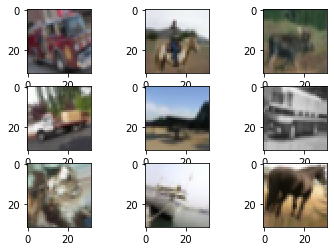

In [9]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

### Model without augmented data

In [10]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    #flat = layers.Flatten()(AvgPooling)
    #print(flat.shape)
    output = layers.Conv2D(10,2,activation='softmax')(AvgPooling)
    #print(output.shape)
    output = Reshape((10,))(output)
    #print(output.shape)
    #model.add(Reshape((-1, 2, 2)))
    #output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [11]:
num_filter = 30
dropout_rate = 0.2
l = 8
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

W1120 19:54:55.745724 13960 deprecation.py:506] From C:\Users\user\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


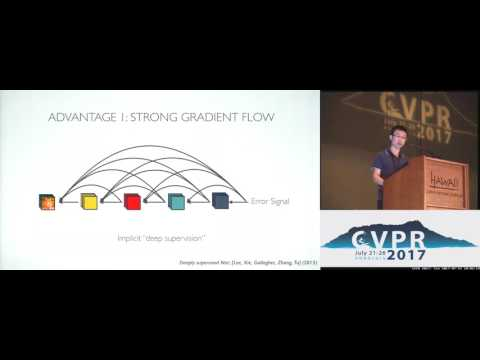

In [12]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [13]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 30)   810         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 30)   120         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 30)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [15]:
model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test))

Train on 50000 samples, validate on 10000 samples


W1120 19:55:00.599825 13960 deprecation.py:323] From C:\Users\user\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
50000/50000 [==============================] - 41s 823us/sample - loss: 1.5205 - acc: 0.4386 - val_loss: 1.3896 - val_acc: 0.4965
Epoch 2/10
50000/50000 [==============================] - 36s 717us/sample - loss: 1.0982 - acc: 0.6048 - val_loss: 1.1493 - val_acc: 0.6072
Epoch 3/10
50000/50000 [==============================] - 36s 717us/sample - loss: 0.9201 - acc: 0.6736 - val_loss: 1.3172 - val_acc: 0.5754
Epoch 4/10
50000/50000 [==============================] - 36s 718us/sample - loss: 0.8156 - acc: 0.7097 - val_loss: 0.9007 - val_acc: 0.7041
Epoch 5/10
50000/50000 [==============================] - 36s 718us/sample - loss: 0.7434 - acc: 0.7369 - val_loss: 0.7686 - val_acc: 0.7362
Epoch 6/10
50000/50000 [==============================] - 36s 719us/sample - loss: 0.6893 - acc: 0.7572 - val_loss: 1.3850 - val_acc: 0.6102
Epoch 7/10
50000/50000 [==============================] - 36s 721us/sample - loss: 0.6432 - acc: 0.7747 - val_loss: 0.7889 - val_acc: 0.7493
Epoch 8/10
50

In [16]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 3s 259us/sample - loss: 0.8518 - acc: 0.7311
Test loss: 0.8518377923488617
Test accuracy: 0.7311


In [17]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


<br>

### Model with augmented data

In [18]:
num_filter = 30
dropout_rate = 0.2
l = 8
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [19]:
model1 = Model(inputs=[input], outputs=[output])
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 32, 32, 30)   810         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 32, 32, 30)   120         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 32, 32, 30)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [20]:
# determine Loss function and Optimizer
model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [21]:
import tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint
#from tf.keras.callbacks import ModelCheckpoint
filepath="DNST_model_with_augmentation.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [22]:
epochs = 300
batch_size=128
#datagen.flow(x_train, y_train, batch_size=128)
model1.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch = len(X_train) / batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test),callbacks=callbacks_list)

Epoch 1/300
390/390 [============================>.] - ETA: 0s - loss: 1.5828 - acc: 0.4118
Epoch 00001: val_acc improved from -inf to 0.46860, saving model to DNST_model_with_augmentation.hdf5
391/390 [==============================] - 60s 154ms/step - loss: 1.5822 - acc: 0.4121 - val_loss: 1.6314 - val_acc: 0.4686
Epoch 2/300
390/390 [============================>.] - ETA: 0s - loss: 1.2251 - acc: 0.5543
Epoch 00002: val_acc improved from 0.46860 to 0.52820, saving model to DNST_model_with_augmentation.hdf5
391/390 [==============================] - 38s 96ms/step - loss: 1.2252 - acc: 0.5544 - val_loss: 1.4968 - val_acc: 0.5282
Epoch 3/300
390/390 [============================>.] - ETA: 0s - loss: 1.0731 - acc: 0.6153
Epoch 00003: val_acc improved from 0.52820 to 0.55770, saving model to DNST_model_with_augmentation.hdf5
391/390 [==============================] - 38s 97ms/step - loss: 1.0732 - acc: 0.6153 - val_loss: 1.5441 - val_acc: 0.5577
Epoch 4/300
390/390 [=====================

Epoch 59/300
390/390 [============================>.] - ETA: 0s - loss: 0.3639 - acc: 0.8732
Epoch 00059: val_acc did not improve from 0.85950
391/390 [==============================] - 38s 98ms/step - loss: 0.3638 - acc: 0.8732 - val_loss: 0.5298 - val_acc: 0.8477
Epoch 60/300
390/390 [============================>.] - ETA: 0s - loss: 0.3616 - acc: 0.8731
Epoch 00060: val_acc did not improve from 0.85950
391/390 [==============================] - 38s 97ms/step - loss: 0.3616 - acc: 0.8731 - val_loss: 0.5645 - val_acc: 0.8332
Epoch 61/300
390/390 [============================>.] - ETA: 0s - loss: 0.3661 - acc: 0.8717
Epoch 00061: val_acc did not improve from 0.85950
391/390 [==============================] - 38s 96ms/step - loss: 0.3659 - acc: 0.8717 - val_loss: 0.5021 - val_acc: 0.8563
Epoch 62/300
390/390 [============================>.] - ETA: 0s - loss: 0.3593 - acc: 0.8747
Epoch 00062: val_acc did not improve from 0.85950
391/390 [==============================] - 38s 96ms/step - 

390/390 [============================>.] - ETA: 0s - loss: 0.2856 - acc: 0.8984
Epoch 00119: val_acc did not improve from 0.88230
391/390 [==============================] - 38s 96ms/step - loss: 0.2854 - acc: 0.8985 - val_loss: 0.4338 - val_acc: 0.8763
Epoch 120/300
390/390 [============================>.] - ETA: 0s - loss: 0.2812 - acc: 0.9026
Epoch 00120: val_acc did not improve from 0.88230
391/390 [==============================] - 38s 96ms/step - loss: 0.2811 - acc: 0.9026 - val_loss: 0.4164 - val_acc: 0.8784
Epoch 121/300
390/390 [============================>.] - ETA: 0s - loss: 0.2816 - acc: 0.9005
Epoch 00121: val_acc did not improve from 0.88230
391/390 [==============================] - 39s 99ms/step - loss: 0.2817 - acc: 0.9005 - val_loss: 0.4109 - val_acc: 0.8749
Epoch 122/300
390/390 [============================>.] - ETA: 0s - loss: 0.2796 - acc: 0.9018
Epoch 00122: val_acc did not improve from 0.88230
391/390 [==============================] - 38s 97ms/step - loss: 0.27

390/390 [============================>.] - ETA: 0s - loss: 0.2465 - acc: 0.9128
Epoch 00179: val_acc did not improve from 0.89990
391/390 [==============================] - 38s 97ms/step - loss: 0.2465 - acc: 0.9128 - val_loss: 0.4470 - val_acc: 0.8744
Epoch 180/300
390/390 [============================>.] - ETA: 0s - loss: 0.2444 - acc: 0.9138
Epoch 00180: val_acc did not improve from 0.89990
391/390 [==============================] - 38s 98ms/step - loss: 0.2445 - acc: 0.9138 - val_loss: 0.4882 - val_acc: 0.8706
Epoch 181/300
390/390 [============================>.] - ETA: 0s - loss: 0.2445 - acc: 0.9139- ETA: 1s - loss: 0.2
Epoch 00181: val_acc did not improve from 0.89990
391/390 [==============================] - 38s 97ms/step - loss: 0.2445 - acc: 0.9139 - val_loss: 0.3979 - val_acc: 0.8843
Epoch 182/300
390/390 [============================>.] - ETA: 0s - loss: 0.2439 - acc: 0.9145
Epoch 00182: val_acc did not improve from 0.89990
391/390 [==============================] - 38s 9

Epoch 240/300
390/390 [============================>.] - ETA: 0s - loss: 0.2235 - acc: 0.9220
Epoch 00240: val_acc did not improve from 0.90240
391/390 [==============================] - 38s 97ms/step - loss: 0.2237 - acc: 0.9219 - val_loss: 0.5174 - val_acc: 0.8624
Epoch 241/300
390/390 [============================>.] - ETA: 0s - loss: 0.2206 - acc: 0.9215
Epoch 00241: val_acc did not improve from 0.90240
391/390 [==============================] - 38s 98ms/step - loss: 0.2208 - acc: 0.9215 - val_loss: 0.4166 - val_acc: 0.8874
Epoch 242/300
390/390 [============================>.] - ETA: 0s - loss: 0.2144 - acc: 0.9249
Epoch 00242: val_acc did not improve from 0.90240
391/390 [==============================] - 38s 98ms/step - loss: 0.2146 - acc: 0.9248 - val_loss: 0.3950 - val_acc: 0.8875
Epoch 243/300
390/390 [============================>.] - ETA: 0s - loss: 0.2166 - acc: 0.9229
Epoch 00243: val_acc did not improve from 0.90240
391/390 [==============================] - 38s 97ms/ste

In [23]:
# Test the model
score = model1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 3s 262us/sample - loss: 0.3993 - acc: 0.8922
Test loss: 0.3993266311496496
Test accuracy: 0.8922


In [24]:
# Save the trained weights in to .h5 format
model1.save_weights("DNST_model_with_augmentation.h5")
print("Saved model to disk")

Saved model to disk
